### Problem
Consider a transport equation 
$$
2u_t+3u_x=0
$$
with boundary condition
$$
u(0,x) = f(x) = e^{-cos(x)}.
$$
The analytical solution is given by
$$
u(t,x) = f(x-\frac{3}{2}t) = e^{-cos(x-\frac{3}{2}t)}.
$$
Our goal is to approximate the solution using PINN.

In [2]:
import torch
from torch import nn, autograd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
batch_size = 256

In [4]:
class PINN(nn.Module):
    def __init__(self) -> None:
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2,5),
            nn.Sigmoid(),
            nn.Linear(5,5),
            nn.Sigmoid(),
            nn.Linear(5,5),
            nn.Sigmoid(),
            nn.Linear(5,1),
            nn.Sigmoid(),
        )
    def forward(self,x,t):
        input = torch.cat([x,t],dim=1)
        output = self.net(input)
        return output

In [5]:
model = PINN().to(device)
mse = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [6]:
## PDE as loss function. 
def f(x,t, model):
    u = model(x,t) 
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    pde = u_t-1.5*u_x
    return pde

In [7]:
x_bc = np.random.uniform(low=0.0, high=2.0, size=(500,1))
t_bc = np.zeros((500,1))
# compute u based on BC
u_bc = np.exp(-np.cos(x_bc))

In [8]:
epochs = 100000
for epoch in range(epochs):
    optimizer.zero_grad() 
    
    # Loss based on boundary conditions
    pt_x_bc = torch.tensor(x_bc,requires_grad=False).float().to(device)
    pt_t_bc = torch.tensor(t_bc,requires_grad=False).float().to(device)
    pt_u_bc = torch.tensor(u_bc,requires_grad=False).float().to(device)
    
    uxt = model(pt_x_bc, pt_t_bc) # output of u(x,t)
    mse_u = mse(uxt, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=0.0, high=2.0, size=(500,1))
    t_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1))
    zeros = np.zeros((500,1))
    
    pt_x_collocation = torch.tensor(x_collocation,requires_grad=True).float().to(device)
    pt_t_collocation = torch.tensor(t_collocation,requires_grad=True).float().to(device)
    pt_all_zeros = torch.tensor(zeros,requires_grad=False).float().to(device)
    
    f_out = f(pt_x_collocation, pt_t_collocation, model) # output of f(x,t)
    mse_f = mse(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_u + mse_f
    
    loss.backward() 
    optimizer.step() 

    with torch.autograd.no_grad():
        print(epoch,"Traning Loss: {:.3f}".format(loss.item()))

0 Traning Loss: 0.132
1 Traning Loss: 0.132
2 Traning Loss: 0.131
3 Traning Loss: 0.131
4 Traning Loss: 0.131
5 Traning Loss: 0.130
6 Traning Loss: 0.130
7 Traning Loss: 0.130
8 Traning Loss: 0.130
9 Traning Loss: 0.129
10 Traning Loss: 0.129
11 Traning Loss: 0.129
12 Traning Loss: 0.128
13 Traning Loss: 0.128
14 Traning Loss: 0.128
15 Traning Loss: 0.128
16 Traning Loss: 0.127
17 Traning Loss: 0.127
18 Traning Loss: 0.127
19 Traning Loss: 0.127
20 Traning Loss: 0.126
21 Traning Loss: 0.126
22 Traning Loss: 0.126
23 Traning Loss: 0.126
24 Traning Loss: 0.125
25 Traning Loss: 0.125
26 Traning Loss: 0.125
27 Traning Loss: 0.125
28 Traning Loss: 0.124
29 Traning Loss: 0.124
30 Traning Loss: 0.124
31 Traning Loss: 0.124
32 Traning Loss: 0.124
33 Traning Loss: 0.123
34 Traning Loss: 0.123
35 Traning Loss: 0.123
36 Traning Loss: 0.123
37 Traning Loss: 0.123
38 Traning Loss: 0.122
39 Traning Loss: 0.122
40 Traning Loss: 0.122
41 Traning Loss: 0.122
42 Traning Loss: 0.122
43 Traning Loss: 0.12

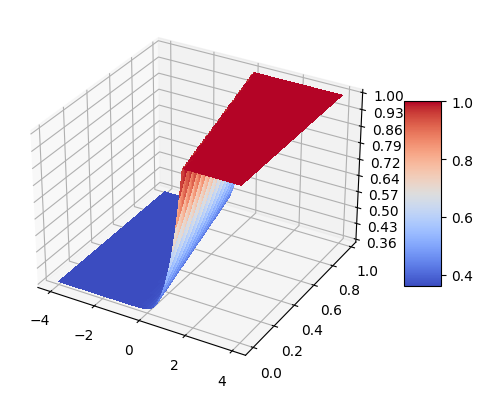

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = plt.axes(projection='3d')


x=np.arange(-4,4,0.02)
t=np.arange(0,1,0.02)
ms_x, ms_t = np.meshgrid(x, t)
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = torch.tensor(x, requires_grad=True).float()
pt_t = torch.tensor(t, requires_grad=True).float()
pt_u = model(pt_x,pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
             
             

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()